<a href="https://colab.research.google.com/github/mj-woo/Deep-Learning/blob/main/Deep_Learning_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Load UCI Covertype Dataset
from sklearn.datasets import fetch_covtype
dataset = fetch_covtype()
X, y = dataset.data, dataset.target - 1  # Labels should start from 0

In [4]:
# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(464809, 54)
(116203, 54)
(464809,)
(116203,)


In [5]:
# Select a single batch for overfitting
batch_size = 128
X_train_batch, y_train_batch = X_train[:batch_size], y_train[:batch_size]

In [6]:
# Define the Residual Block
def residual_block(input_tensor, units):
    x = Dense(units, activation='relu')(input_tensor)
    x = Dense(units, activation='relu')(x)

    # Residual Connection (linear projection if shape mismatch)
    if input_tensor.shape[-1] != units:
        input_tensor = Dense(units)(input_tensor)
    x = Add()([x, input_tensor])
    return x

In [7]:
# Build the MLP with Residual and Skip Connections
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
res_out = residual_block(x, 64)  # Residual block

In [10]:
# Additional skip connection (bypassing layers)
skip_out = Dense(32, activation='relu')(inputs)
x = Dense(32, activation='relu')(res_out)
x = Add()([x, skip_out])

outputs = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs, outputs)

In [11]:
# Compile the model
model.compile(optimizer=SGD(learning_rate=0.01),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
# Train only on one batch
history = model.fit(X_train_batch, y_train_batch, epochs=500, verbose=0)

In [13]:
# Evaluate on full validation set
train_loss, train_acc = model.evaluate(X_train_batch, y_train_batch, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

In [14]:
# Print results
print(f"Number of parameters: {model.count_params()}")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

Number of parameters: 15911
Final training loss: 0.0606
Final validation loss: 2.3882


In [18]:
# Save model architecture to JSON
model_json = model.to_json()
with open("mlp_residual_skip.json", "w") as json_file:
    json_file.write(model_json)

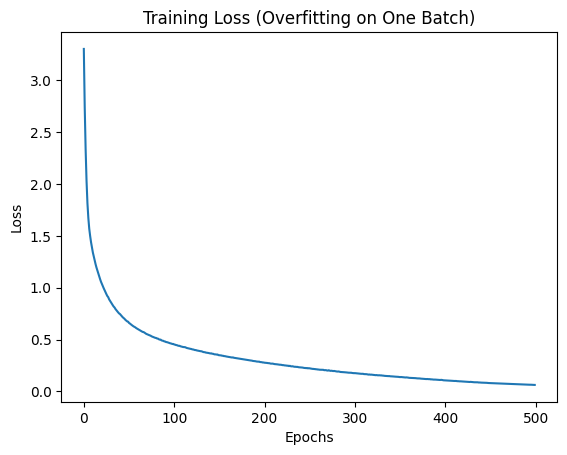

In [19]:
# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (Overfitting on One Batch)')
plt.show()